In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [4]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(96, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
def get_data_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    trainloader = DataLoader(
        trainset, batch_size=batch_size,shuffle=True, num_workers=2
    )

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return trainloader, testloader

In [6]:
def train_model(model, trainloader, testloader, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(20):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}')
    return model

In [7]:
def evaluate_and_visualize(model, testloader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    images = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            images.extend(inputs.cpu().numpy())
    accuracy = correct / total
    print(f'Test accuracy: {accuracy:.4f}')

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images[i].transpose((1, 2, 0)) * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'True: {class_names[true_labels[i]]}\nPred: {class_names[predictions[i]]}')
        plt.axis('off')
    plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
print(f'Using device: {device}')

Using device: cuda


In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
trainloader, testloader = get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [12]:
model = AlexNet().to(device)

In [13]:
model = train_model(model, trainloader, testloader, device)

Epoch 1, Loss: 1.6480
Epoch 2, Loss: 1.1326
Epoch 3, Loss: 0.8911
Epoch 4, Loss: 0.7523
Epoch 5, Loss: 0.6540
Epoch 6, Loss: 0.5785
Epoch 7, Loss: 0.5309
Epoch 8, Loss: 0.4886
Epoch 9, Loss: 0.4474
Epoch 10, Loss: 0.4208
Epoch 11, Loss: 0.3873
Epoch 12, Loss: 0.3590
Epoch 13, Loss: 0.3363
Epoch 14, Loss: 0.3161
Epoch 15, Loss: 0.2972
Epoch 16, Loss: 0.2809
Epoch 17, Loss: 0.2624
Epoch 18, Loss: 0.2457
Epoch 19, Loss: 0.2373
Epoch 20, Loss: 0.2276


Test accuracy: 0.8716


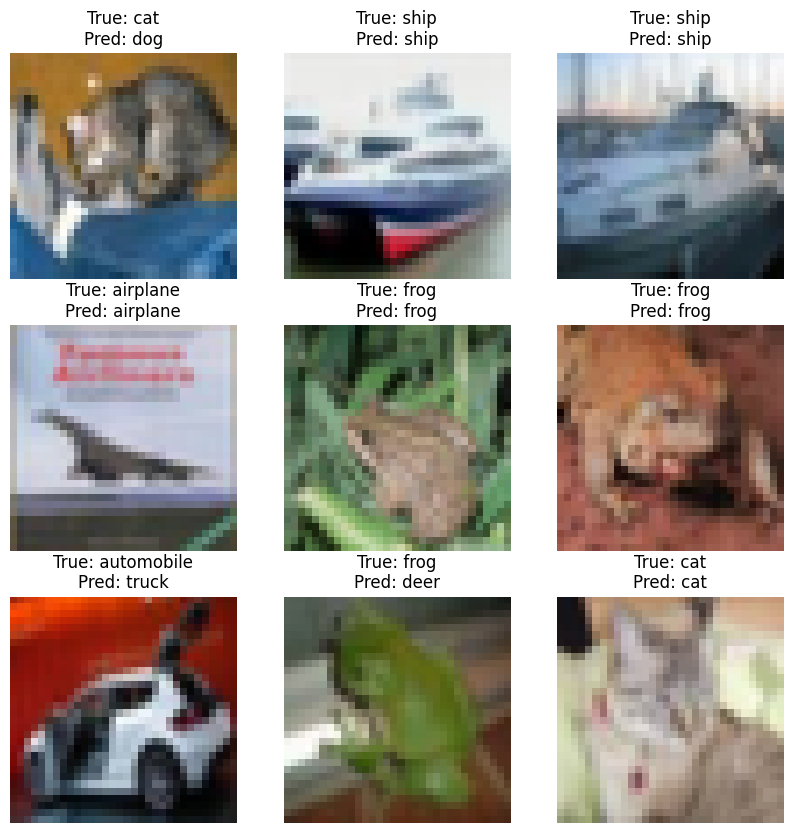

In [14]:
evaluate_and_visualize(model, testloader, device, class_names)